In [141]:
pwd

'/Users/peterchatain/Documents/Classes/CS329P/project/riiid-test-answer-prediction'

In [142]:
import os
import math
import random
import numpy as np
import pandas as pd
from collections import defaultdict
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import gc
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, log_loss, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from torch import nn
import sys
%cd /Users/peterchatain/Documents/Classes/CS329P/project/riiid-test-answer-prediction
%ls

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


/Users/peterchatain/Documents/Classes/CS329P/project/riiid-test-answer-prediction
cv1_train.pickle                     cv1_valid.pickle.zip
cv1_train.pickle.zip                 cv1_valid_100k.pickle
cv1_train_1000k.pickle               example_sample_submission.csv
cv1_train_1000k_preprocessed.pickle  example_test.csv
cv1_train_100k.pickle                lectures.csv
cv1_train_100k_preprocessed.pickle   questions.csv
cv1_val_100k_preprocessed.pickle     riiid-test-answer-prediction.zip
cv1_val_10k.pickle                   riiideducation/
cv1_val_10k_preprocessed.pickle      train.csv
cv1_valid.pickle
cpu


In [189]:
train_path = "cv1_train_100k.pickle"
valid_path = "cv1_valid_100k.pickle"
question_path = "questions.csv"
lecture_path = "lectures.csv"
train = pd.read_pickle(train_path)
valid = pd.read_pickle(valid_path)
questions =  pd.read_csv(question_path)
lectures =  pd.read_csv(lecture_path)

def clean_df(train, is_valid = False, train_mean = 0, train_std = 0):

  train = train.sort_values(['user_id', 'timestamp'])
  train = train.reset_index(drop=True)
  train = train.drop(np.where(train['content_type_id'] == 1)[0], axis=0)
  train = train.reset_index(drop=True)
  train['part'] = np.array(questions['part'])[np.array(train['content_id'])]
  train = pd.concat([train, pd.get_dummies(train.part, prefix='part')], axis = 1)
  train = train.drop(["row_id", "content_id", "content_type_id", "task_container_id", "user_answer", "max_time_stamp", "rand_time_stamp", "viretual_time_stamp", "part"], axis=1)
  train.drop_duplicates(['user_id','timestamp' ], inplace = True)
  normalize_cols = ["prior_question_elapsed_time"]
  if not is_valid:
    train_mean = train[normalize_cols].mean()
    train_std = train[normalize_cols].std()
  train[normalize_cols] = (train[normalize_cols] - train_mean) / train_std
  train = train.fillna(0)
  return train, train_mean, train_std
train, train_mean, train_std = clean_df(train)
valid ,_, _ = clean_df(valid, is_valid = True, train_mean = train_mean, train_std = train_std)


In [190]:
user_id_train = set(np.unique(train["user_id"]))
user_id_valid = set(np.unique(valid["user_id"]))
intersection = user_id_train.intersection(user_id_valid)
print("there are {} unique users in train and {} unique users in valid, there are {} duplicate users : {}".format(len(user_id_train), len(user_id_valid), len(intersection), intersection))

for duplicate_user in intersection:
  valid = valid[valid["user_id"]!=duplicate_user]

train = train.reset_index(drop=True)

valid = valid.reset_index(drop=True)



there are 2210 unique users in train and 2824 unique users in valid, there are 2 duplicate users : {124443281, 1209880307}


In [191]:
mapmap_train = np.unique(train["user_id"], return_counts = True)[1]
mapmap_valid = np.unique(valid["user_id"], return_counts = True)[1]

mu = np.mean(train['answered_correctly'])
sigma = np.std(train['answered_correctly'])
train['prior_answered_correctly'] = (train['answered_correctly'] - mu) / sigma

temp = np.append(0, train['prior_answered_correctly'][0:-1])
temp[np.cumsum(mapmap_train)[:-1]] = 0
train['prior_answered_correctly']= temp

print(f"mu = {mu}, sigma = {sigma}")


mu = np.mean(valid['answered_correctly'])
sigma = np.std(valid['answered_correctly'])
valid['prior_answered_correctly'] = (valid['answered_correctly'] - mu) / sigma

print(f"mu = {mu}, sigma = {sigma}")

temp = np.append(0, valid['prior_answered_correctly'][0:-1])
temp[np.cumsum(mapmap_valid)[:-1]] = 0
valid['prior_answered_correctly']= temp


valid['prior_answered_correctly'] = (valid['prior_answered_correctly']>0) + 0
train['prior_answered_correctly'] = (train['prior_answered_correctly']>0) + 0



mu = 0.5826356667339117, sigma = 0.49312406814456117
mu = 0.6522629586213401, sigma = 0.47625202512102355


In [192]:
train

,timestamp,user_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,part_1,part_2,part_3,part_4,part_5,part_6,part_7,prior_answered_correctly
0,0,44331,0,0.000000,False,0,0,0,0,1,0,0,0
1,35028,44331,0,1.339109,False,0,0,0,0,1,0,0,0
2,61706,44331,1,0.571721,False,0,0,0,0,1,0,0,0
3,85685,44331,0,0.060129,False,0,1,0,0,0,0,0,1
4,141228,44331,1,-0.131718,False,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79307,223228,2144322103,1,0.124078,False,0,0,0,0,1,0,0,1
79308,246293,2144322103,1,-0.131718,False,0,1,0,0,0,0,0,1
79309,370646,2144322103,1,-0.387514,False,0,1,0,0,0,0,0,1
79310,403714,2144322103,1,-0.451463,True,0,1,0,0,0,0,0,1


In [53]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74217 entries, 0 to 74216
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   timestamp                       74217 non-null  int64  
 1   user_id                         74217 non-null  int32  
 2   answered_correctly              74217 non-null  int8   
 3   prior_question_elapsed_time     74217 non-null  float32
 4   prior_question_had_explanation  74217 non-null  boolean
 5   part_1                          74217 non-null  uint8  
 6   part_2                          74217 non-null  uint8  
 7   part_3                          74217 non-null  uint8  
 8   part_4                          74217 non-null  uint8  
 9   part_5                          74217 non-null  uint8  
 10  part_6                          74217 non-null  uint8  
 11  part_7                          74217 non-null  uint8  
 12  prior_answered_correctly        

In [174]:
print("train", train.shape)
print("valid", valid.shape)


train (79312, 13)
valid (7456, 13)


In [ ]:
# mapmap_train = np.unique(train["user_id"], return_counts = True)[1]
# mapmap_valid = np.unique(valid["user_id"], return_counts = True)[1]
# plt.plot(mapmap_train)
# plt.plot(mapmap_valid

In [ ]:
# create a histogram of the 

In [193]:
from tqdm import tqdm

WINDOW_LENGTH = 256
FEATURE_DIM = train.shape[1]

def add_window_padding(train):
    train_padded = list()
    loss_mask = list()
    mapmap = np.unique(train['user_id'], return_counts=True)[1]
    lower = np.cumsum(mapmap)
    start = 0
    for l, m in tqdm(zip(lower, mapmap)):
        someee = (((l-start-1)//WINDOW_LENGTH)+1)*WINDOW_LENGTH
        end_index = start + someee
        padded = end_index - l
        temp = np.zeros((1, someee, FEATURE_DIM))
        mask = np.zeros((1, someee))
        temp[:,:l-start] = np.array(train.iloc[start:l], dtype = np.float)
        mask[:, :l-start] =1
        temp = np.reshape(temp, (-1,WINDOW_LENGTH,FEATURE_DIM))
        mask = np.reshape(mask, (-1, WINDOW_LENGTH))
        #Append
        train_padded.append(temp)
        loss_mask.append(mask)
        #Update start
        start = l
    train_padded = np.vstack(train_padded)
    train_padded = torch.from_numpy(train_padded).to(device)
    loss_mask = np.vstack(loss_mask)
    loss_mask = torch.from_numpy(loss_mask).to(device)
    return train_padded, mapmap, loss_mask

train_padded, mapmap_train, loss_mask_train = add_window_padding(train)
valid_padded, mapmap_valid, loss_mask_valid= add_window_padding(valid)

0it [00:00, ?it/s]/var/folders/l_/9kp_4l1d14g94h3qntsw3w7m0000gn/T/ipykernel_47189/1854552066.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  temp[:,:l-start] = np.array(train.iloc[start:l], dtype = np.float)
2210it [00:00, 3295.05it/s]
2822it [00:00, 3453.62it/s]


In [194]:
t_train_y =train_padded[:,:,2:3] > 0 
t_train_x = train_padded[:,:,3:]
print(t_train_y.shape)
print(t_train_x.shape)
print(loss_mask_train.shape)

t_valid_y =valid_padded[:,:,2:3] > 0
t_valid_x = valid_padded[:,:,3:]
print(t_valid_y.shape)
print(t_valid_x.shape)
print(loss_mask_valid.shape)

torch.Size([2235, 256, 1])
torch.Size([2235, 256, 10])
torch.Size([2235, 256])
torch.Size([2836, 256, 1])
torch.Size([2836, 256, 10])
torch.Size([2836, 256])


In [195]:
batch_size = 16

def batchify(t_train_x, t_train_y, loss_mask_train, batch_size):
  
  total = (t_train_y.shape[0]//batch_size-1)*batch_size
  t_train_y = t_train_y[:total]
  t_train_x = t_train_x[:total, :, :] 
  loss_mask_train = loss_mask_train[:total,:]
  num_batches = int(t_train_y.shape[0] / batch_size)
  t_train_x = t_train_x.reshape(num_batches, batch_size, WINDOW_LENGTH, 10)
  t_train_y = t_train_y.reshape(num_batches,batch_size, -1)
  loss_mask_train = loss_mask_train.reshape(num_batches, batch_size, -1)
  print(t_train_x.shape)
  print(t_train_y.shape)
  print(loss_mask_train.shape)
  return t_train_x, t_train_y, loss_mask_train
t_train_x, t_train_y , loss_mask_train=  batchify(t_train_x, t_train_y, loss_mask_train, batch_size)
t_valid_x, t_valid_y , loss_mask_valid=  batchify(t_valid_x, t_valid_y, loss_mask_valid,batch_size)

torch.Size([138, 16, 256, 10])
torch.Size([138, 16, 256])
torch.Size([138, 16, 256])
torch.Size([176, 16, 256, 10])
torch.Size([176, 16, 256])
torch.Size([176, 16, 256])


In [196]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int = 9, dropout: float = 0.1, max_len: int = 512):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x.permute(1, 0, 2) + self.pe[:x.size(1)]
        x = x.permute(1, 0, 2)
        return self.dropout(x)


In [197]:
class TransformerModel(torch.nn.Module):
    def __init__(self, n_encoder_layers=3, d_model=9, n_heads=3, dropout = 0.1):
        super(TransformerModel, self).__init__()
        self.n_encoder_layers = n_encoder_layers
        self.d_model = d_model
        self.positional_encoding = PositionalEncoding(d_model)
        self.tranformer_encoder = TransformerModelEncoder(n_encoder_layers, d_model, n_heads,dropout)
        self.decoder = torch.nn.Linear(d_model, 1)
    def forward(self, X):
        X = self.positional_encoding(X)
        out = self.tranformer_encoder(X)
        out = self.decoder(out)
        return out

In [198]:
class TransformerModelEncoder(torch.nn.Module):
    def __init__(self, n_encoder_layers=3, d_model=9, n_heads=3, dropout= 0.1):
        super(TransformerModelEncoder, self).__init__()
        self.encoder = []
        self.n_encoder_layers = n_encoder_layers
        for i in range(n_encoder_layers):
            self.encoder.append(TransformerEncoderLayer(n_heads,d_model, dropout))
    def forward(self, X):
        for i in range(self.n_encoder_layers):
            X = self.encoder[i](X)
        return X

In [199]:
class TransformerEncoderLayer(torch.nn.Module):
    def __init__(self, n_heads=3,d_model=9, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.attention = MultiheadAttention(n_heads,d_model, dropout)
        self.linear = torch.nn.Linear(d_model, d_model)
        self.linear2 = torch.nn.Linear(d_model, d_model)
        self.dropout = torch.nn.Dropout(dropout)
        self.layer_norm = torch.nn.LayerNorm([WINDOW_LENGTH, d_model])
    def forward(self, X):
        oldX = X
        X = self.attention(X)
        X = self.linear(X) 
        X = self.layer_norm(self.dropout(X) + oldX)
        return X

In [200]:
class MultiheadAttention(torch.nn.Module):
    #Note that d_model should be divisible by the number of heads (n_heads)
    def __init__(self, n_heads=3, d_model=9, dropout=0.1):
        super(MultiheadAttention, self).__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.dropout = dropout
        self.small_d = d_model//n_heads
        
        self.Q = torch.nn.Linear(d_model, d_model)
        self.K = torch.nn.Linear(d_model, d_model)
        self.V = torch.nn.Linear(d_model, d_model)
        self.dropout = torch.nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm([WINDOW_LENGTH, d_model])
    #Note that X is input with the size (# of strings, Max Length of strings, #features of string)
    def forward(self, X):
        q_X = self.Q(X)
        k_X =  self.K(X)
        v_X =  self.V(X)
        max_len = X.shape[1]
        batch_size = X.shape[0]
        q_X_h = q_X.reshape(batch_size, -1, self.n_heads, self.small_d).permute(0,2,1,3)
        k_X_h = k_X.reshape(batch_size, -1, self.n_heads, self.small_d).permute(0,2,3,1)
        v_X_h = v_X.reshape(batch_size, -1, self.n_heads, self.small_d).permute(0, 2, 1, 3)
        mask = torch.triu(torch.ones(max_len,max_len)*float('-inf'), diagonal=1)
        score = torch.softmax((q_X_h @ k_X_h)/np.sqrt(self.small_d) + mask, axis = -1)
                
        result = (score@v_X_h).permute(0, 2, 1, 3)
        result = result.reshape(batch_size, max_len, self.d_model)
        result = self.layer_norm(X + self.dropout(result))
        return result

In [201]:
Q = torch.randn((9, 15))
K = torch.randn((9, 15))
V = torch.randn((9, 15))
small_d = 5
n_heads = 3

X = t_train_x[0]

# Train LSTM

In [202]:
all_preds = []
all_preds2 = []
def evaluate_rnn(transformer_model, t_valid_x, t_valid_y, loss_mask_valid, name_data = ""):
    transformer_model.eval()
    with torch.no_grad():
      acc = 0
      count = 0
      acc_total = 0
      loss_total = 0
      num_batches = t_valid_x.shape[0]
      for batch in range(29):
          src = t_valid_x[batch,:,:,:].to(device).float()
          tgt = t_valid_y[batch] + 0
          loss_mask_batch = loss_mask_valid[batch, :, :]
          out, _ = transformer_model(src)
          out = torch.sigmoid(out[:,:, [0]]).squeeze(-1)
          if batch == 0:
              out_all = out
              tgt_all = tgt
          else:
              out_all = torch.cat((out_all, out), dim = 0)
              tgt_all = torch.cat((tgt_all, tgt), dim = 0)
          prediction = out>0.5
          all_preds.append(prediction)
          acc = torch.sum((tgt== prediction) *(loss_mask_batch))
          loss = torch.sum((-tgt*torch.log(out) -(1-tgt)*torch.log(1-out))*loss_mask_batch)/torch.sum(loss_mask_batch)
          loss_total += loss
          acc_total += acc
          count+= torch.sum(loss_mask_batch)
      print(f"tgts_all has shape {tgt_all.shape}")
      print(f"and preds_all has shape {out_all.shape}")
      print(f"there are {np.unique(tgt_all)} elements in tgt_all")
      print(f"there are {len(np.unique(out_all))} unique elements in out_all")
      print(f"the data type of tgt_all is {type(tgt_all)}")
      print(f"the data type of out_all is {type(out_all)}")
      out_all = out_all.cpu().numpy()
      tgt_all = tgt_all.cpu().numpy()
      print(f"the data type of tgt_all is now {type(tgt_all)}")
      print(f"the data type of out_all is now {type(out_all)}")
      print(f"the shape of tgt_all is now {tgt_all.shape}")
      print(f"the shape of out_all is now {out_all.shape}")
      # all_types_of_labels = set()
      # for i in range(tgt_all.shape[0]):
      #   for j in range(tgt_all.shape[1]):
      #     all_types_of_labels.add(tgt_all[i][j])
      # print(f"all labels set is {all_types_of_labels}")
      roc_auc_score_total = roc_auc_score(tgt_all, out_all)
      print("evaluation of {} has acc: {}, loss: {}, auc: {}".format(name_data, acc_total/count, loss_total / count, roc_auc_score_total))
    return acc_total/count, loss_total / count, roc_auc_score_total

num_batches = t_train_x.shape[0]
lstm_model = torch.nn.LSTM(10, 10, 2)
optim = torch.optim.Adam(lstm_model.parameters(), lr=0.01)
lstm_model.train()
num_batches = t_train_x.shape[0]
num_epochs = 10
log_interval = 10
total_loss = 0
plot_loss= []
plot_acc= []
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []
train_roc_aucs = []
valid_roc_aucs = []

for epoch in range(num_epochs):
    for batch in tqdm(range(50)):
      optim.zero_grad()
      src = t_train_x[batch,:,:,:].to(device).float()
      tgt = t_train_y[batch] + 0
      loss_mask_batch = loss_mask_train[batch, :, :]
      out, _ = lstm_model(src)
      out = torch.sigmoid(out[:, :, 0]).squeeze(-1)
      prediction = out>0.5
      all_preds_count = 0
      true_pred = 0
      acc = torch.sum((tgt== prediction) *(loss_mask_batch)) /torch.sum(loss_mask_batch)
      plot_acc.append(acc)
      loss = torch.sum((-tgt*torch.log(out) -(1-tgt)*torch.log(1-out))*loss_mask_batch)/torch.sum(loss_mask_batch)
      loss.backward()
      optim.step()
      if (batch+1)%log_interval == 0:
        plot_loss.append(total_loss)
        total_loss = 0
      total_loss += loss.item()
    print("train")
    train_acc, train_loss, train_roc_auc = evaluate_rnn(lstm_model, t_train_x,  t_train_y, loss_mask_train)
    print("valid")
    valid_acc, valid_loss, valid_roc_auc = evaluate_rnn(lstm_model, t_valid_x,  t_valid_y, loss_mask_valid)
    train_losses.append(train_loss.item()), train_accs.append(train_acc*100), train_roc_aucs.append(train_roc_auc)
    valid_losses.append(valid_loss), valid_accs.append(valid_acc*100), valid_roc_aucs.append(valid_roc_auc)

plt.plot(train_losses, label = "train")
plt.plot(valid_losses, label = "valid")
plt.title('Cross Entropy Loss')
plt.xlabel('# Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()
plt.plot(train_accs,  label = "train")
plt.plot(valid_accs,  label = "valid")
plt.title('Accuracy')
plt.xlabel('# Epochs')
plt.ylabel('% Accuracy')
plt.legend()
plt.show()
plt.plot(train_roc_aucs,  label = "train")
plt.plot(valid_roc_aucs,  label = "valid")
plt.title('ROC_AUC')
plt.xlabel('# Epochs')
plt.ylabel('ROC_AUC')
plt.legend()
plt.show()


100%|██████████| 50/50 [00:00<00:00, 77.34it/s]


train
tgts_all has shape torch.Size([464, 256])
and preds_all has shape torch.Size([464, 256])
there are [0 1] elements in tgt_all
there are 34754 unique elements in out_all
the data type of tgt_all is <class 'torch.Tensor'>
the data type of out_all is <class 'torch.Tensor'>
the data type of tgt_all is now <class 'numpy.ndarray'>
the data type of out_all is now <class 'numpy.ndarray'>
the shape of tgt_all is now (464, 256)
the shape of out_all is now (464, 256)
evaluation of  has acc: 0.5706545987634648, loss: 0.0012538727669861812, auc: 0.838983892956255
valid
tgts_all has shape torch.Size([464, 256])
and preds_all has shape torch.Size([464, 256])
there are [0 1] elements in tgt_all
there are 27587 unique elements in out_all
the data type of tgt_all is <class 'torch.Tensor'>
the data type of out_all is <class 'torch.Tensor'>
the data type of tgt_all is now <class 'numpy.ndarray'>
the data type of out_all is now <class 'numpy.ndarray'>
the shape of tgt_all is now (464, 256)
the shape o

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [78]:
total_all_sum = 0
for i in all_preds:
    total_all_sum += i
print(total_all_sum.shape)
print(total_all_sum / len(all_preds))

print(all_preds2)
total_all_sum2 = 0
for i in all_preds2:
    for x in i:
        total_all_sum2 += x
print(total_all_sum2.shape)
print(total_all_sum2 / len(all_preds2))

torch.Size([16, 256])
tensor([[0.7414, 0.8466, 0.7810,  ..., 0.6000, 0.6000, 0.6000],
        [0.7017, 0.8276, 0.7483,  ..., 1.0000, 1.0000, 1.0000],
        [0.8121, 0.8517, 0.8207,  ..., 1.0000, 1.0000, 1.0000],
        ...,
        [0.7586, 0.5845, 0.5466,  ..., 0.9983, 1.0000, 0.9983],
        [0.7552, 0.6724, 0.5845,  ..., 0.9966, 0.9983, 0.9966],
        [0.7155, 0.6397, 0.5914,  ..., 0.9966, 0.9983, 0.9983]])
[<generator object <genexpr> at 0x131e31190>, <generator object <genexpr> at 0x131e31580>, <generator object <genexpr> at 0x131e312e0>, <generator object <genexpr> at 0x131e319e0>, <generator object <genexpr> at 0x131e31900>, <generator object <genexpr> at 0x131e31120>, <generator object <genexpr> at 0x131e31040>, <generator object <genexpr> at 0x1316c3f20>, <generator object <genexpr> at 0x1316c3e40>, <generator object <genexpr> at 0x1316c3d60>, <generator object <genexpr> at 0x1316c3c80>, <generator object <genexpr> at 0x1316c3f90>, <generator object <genexpr> at 0x1316c3

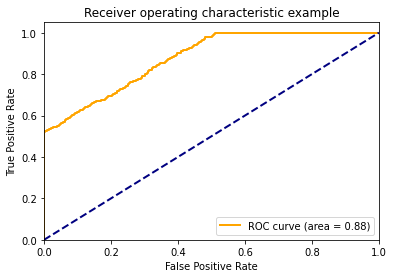

In [123]:

# Example AUC calculation and printing code
from scipy.special import softmax
y_aucs = np.random.randint(0, 2, size=2000)
y_preds_auc = softmax(y_aucs + np.random.uniform(-1,1, size=2000))
# y_aucs =      [1,1,1,1,1,1,1,1,0,0]
# y_preds_auc = [0,.1,.1,.1,.1,.1,.1,.1,.1,0]
roc_auc_score_testing = roc_auc_score(y_aucs, y_preds_auc)
fpr, tpr, thresholds = roc_curve(y_aucs, y_preds_auc)
plt.figure()
lw = 2
# print(fpr)
plt.plot(
    fpr,
    tpr,
    color="orange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc_score_testing,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [131]:
new_test_1 = torch.rand(size=(16, 256))
new_test_2 = torch.rand(size=(16, 256))
new_test_5 = torch.rand(size=(16, 256))
new_test_6 = torch.rand(size=(16, 256))
lst_all_tests = [new_test_1, new_test_2, new_test_5, new_test_6]

for i in range(4):
  if i == 0:
    all_tests = new_test_1
  else:
    all_tests = torch.cat((lst_all_tests[i], all_tests), dim=0)

print(f"shape of all_tests is {all_tests.shape}")

shape of all_tests is torch.Size([64, 256])


# Train transfomer

In [188]:
def evaluate(transformer_model,t_valid_x, t_valid_y , loss_mask_valid, name_data = ""):
    transformer_model.eval()
    with torch.no_grad():
      acc = 0
      count = 0
      acc_total = 0
      loss_total = 0
      num_batches = t_valid_x.shape[0]
      for batch in range(num_batches):

          src = t_valid_x[batch,:,:,:].to(device).float()
          tgt = t_valid_y[batch] + 0
          loss_mask_batch = loss_mask_valid[batch, :, :]
          out = transformer_model(src)
          out = torch.sigmoid(out).squeeze(-1)
          if batch == 0: 
            # initialize objects to keep track of auc
            all_outs = out
            all_tgts = tgt
          else:
            # cat along the rows dimension = 0 since each row is an example.
            all_outs = torch.cat((all_outs, out), dim=0) 
            all_tgts = torch.cat((all_tgts, tgt), dim=0)
  
          prediction = out>0.5
          acc = torch.sum((tgt== prediction) *(loss_mask_batch))
          loss = torch.sum((-tgt*torch.log(out) -(1-tgt)*torch.log(1-out))*loss_mask_batch)/torch.sum(loss_mask_batch)
          loss_total += loss
          acc_total += acc
          count+= torch.sum(loss_mask_batch)
      print(f"the type of all_outs is {type(all_outs)}")
      print(f"the shape of all_outs is {all_outs.shape}")
      print(f"the type of all_tgts is {type(all_tgts)}")
      print(f"the shape of all_tgts is {all_tgts.shape}")
      roc_auc_total = roc_auc_score(all_tgts, all_outs)
      print("evaluation acc of {}: {}, loss: {}, auc: {}".format(name_data, acc_total/count, loss_total / count, roc_auc_total))
    return acc_total/count, loss_total / count, roc_auc_total


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
num_batches = t_train_x.shape[0]
transformer_model = TransformerModel(d_model = 10, n_heads=2, n_encoder_layers=3, dropout = 0.1)
optim = torch.optim.Adam(transformer_model.parameters(), lr=0.001)
transformer_model.train()
num_batches = t_train_x.shape[0]
num_epochs = 8
log_interval = 10
total_loss = 0
plot_loss= []
plot_acc= []
# plot_roc_aucs = []
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []
train_roc_aucs = []
valid_roc_aucs = []
for epoch in range(num_epochs):
    for batch in tqdm(range(num_batches)):
      optim.zero_grad()
      src = t_train_x[batch,:,:,:].to(device).float()
      tgt = t_train_y[batch] + 0
      loss_mask_batch = loss_mask_train[batch, :, :]
      out = transformer_model(src)
      out = torch.sigmoid(out).squeeze(-1)
      prediction = out>0.5
      # plot_roc_aucs.append(roc_auc_score(out, tgt)) # I guess I can't use numpy in here since there's no gradient?
      acc = torch.sum((tgt== prediction) *(loss_mask_batch)) /torch.sum(loss_mask_batch)
      plot_acc.append(acc)
      loss = torch.sum((-tgt*torch.log(out) -(1-tgt)*torch.log(1-out))*loss_mask_batch)/torch.sum(loss_mask_batch)
      loss.backward()
      optim.step()
    train_acc, train_loss, train_auc = evaluate(transformer_model, t_train_x,  t_train_y, loss_mask_train, "train")
    valid_acc, valid_loss, valid_auc = evaluate(transformer_model, t_valid_x,  t_valid_y, loss_mask_valid, "valid")
    train_losses.append(train_loss.item())
    train_accs.append(train_acc*100) 
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc*100)
    train_roc_aucs.append(train_auc)
    valid_roc_aucs.append(valid_auc)
print(f"We finnished training with {num_epochs} epochs")

cpu


100%|██████████| 138/138 [00:10<00:00, 12.85it/s]


the type of all_outs is <class 'torch.Tensor'>
the shape of all_outs is torch.Size([2208, 256])
the type of all_tgts is <class 'torch.Tensor'>
the shape of all_tgts is torch.Size([2208, 256])
evaluation acc of train: 0.5806797990515027, loss: 0.0011923302927201247, auc: 0.4782862348373832
the type of all_outs is <class 'torch.Tensor'>
the shape of all_outs is torch.Size([464, 256])
the type of all_tgts is <class 'torch.Tensor'>
the shape of all_tgts is torch.Size([464, 256])


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

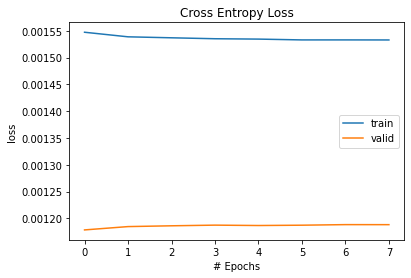

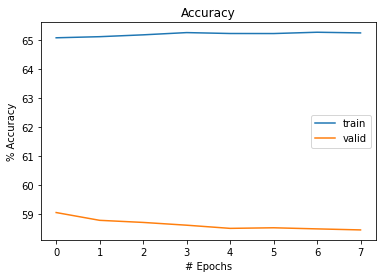

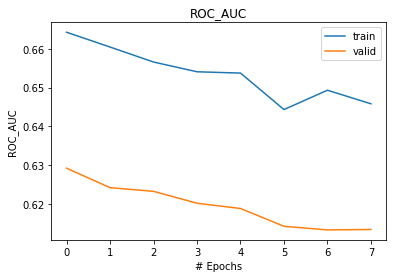

In [156]:
plt.plot(train_losses, label = "train")
plt.plot(valid_losses, label = "valid")
plt.title('Cross Entropy Loss')
plt.xlabel('# Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()
plt.plot(train_accs,  label = "train")
plt.plot(valid_accs,  label = "valid")
plt.title('Accuracy')
plt.xlabel('# Epochs')
plt.ylabel('% Accuracy')
plt.legend()
plt.show()
plt.plot(train_roc_aucs,  label = "train")
plt.plot(valid_roc_aucs,  label = "valid")
plt.title('ROC_AUC')
plt.xlabel('# Epochs')
plt.ylabel('ROC_AUC')
plt.legend()
plt.show()